# **Agricultural drought in central South America - observational analysis**

- Gaussian distribution, scaled with GMST, fitted to logarithm of OND mean precipitation, looking at the lower tails of the distribution
- also check trend in OND temperature against CPC ()
- also provide OND mean precipitation & evaporation so that we can look at the SPEI in the models (this will be fitted here once I've figured out the details)

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *

---
## **Event maps**

### **Drought classification**

In [3]:
# load latest data, discretize to get drought classifications
spi = {ens : xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps", "mswep"]}
spi = {k : xr.apply_ufunc(np.digitize, v, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(v)) for k, v in spi.items()}

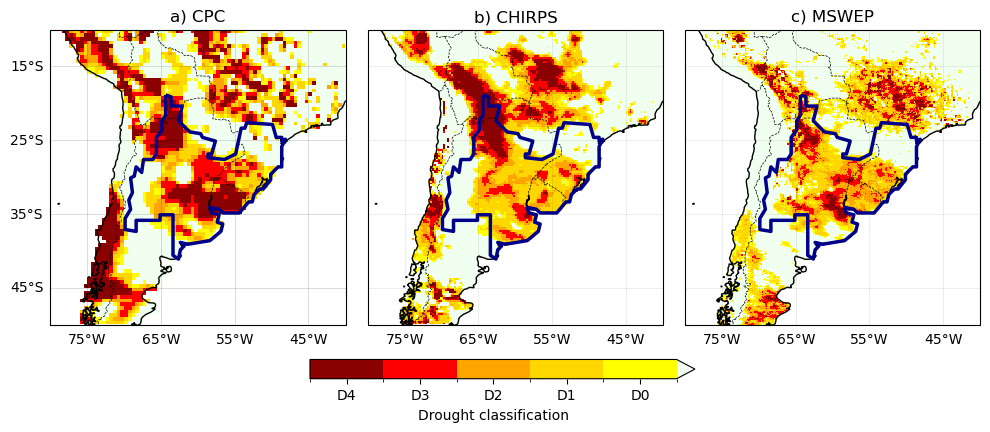

In [10]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

n_ens = len(spi.keys())
fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (12,5), sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0.075)

for i in range(n_ens):
        
    ens = list(spi.keys())[i]
    cbar = spi[ens].plot(ax = axs[i], **plot_kwargs); axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, lw = 2.5, color = "darkblue")
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))

axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.09, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
# plt.suptitle("Drought classification in December 2022 based on 3-month SPI", fontweight = "bold", y = 1.02)

plt.savefig("event-map_spi3_dec22.png")

### **Drought severity & duration**
NB Not available for MSWEP, which only has OND data

In [204]:
from xclim.indices.run_length import rle, _cumsum_reset_on_zero as run_cumsum

for ens in ["cpc", "chirps"]:
    
    da = xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi
    
    # identify drought months (1 if in drought, 0 otherwise)
    idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
    idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
    drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time")
    
    drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
    drought_length.rename("drought_duration").assign_attrs(long_name = "Drought duration", units = "months").to_netcdf("data/"+ens+"_spi3-drought-duration.nc")
    
    drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
    drought_severity.rename("drought_severity").assign_attrs(long_name = "Drought severity").to_netcdf("data/"+ens+"_spi3-drought-severity.nc")

#### **Map of drought duration**

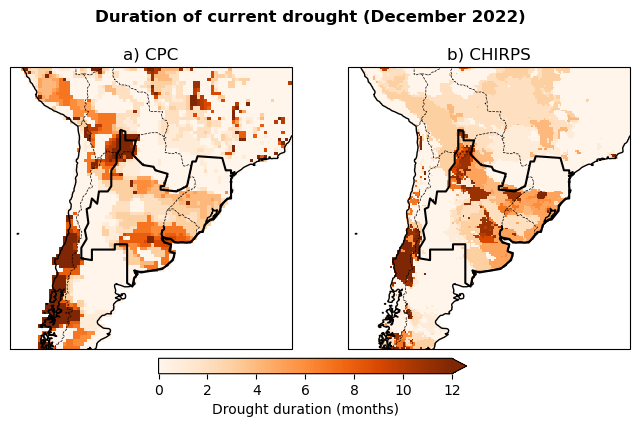

In [208]:
duration = {ens : xr.open_dataset("data/"+ens+"_spi3-drought-duration.nc").drought_duration.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps"]}
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

n_ens = len(duration.keys())
fig, axs = plt.subplots(ncols = n_ens, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (n_ens*4,4))

for i in range(n_ens):
        
    ens = list(duration.keys())[i]
    cbar = duration[ens].plot(ax = axs[i], cmap = "Oranges", add_colorbar = False, vmax = 12)
    axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Drought duration (months)")
    
plt.suptitle("Duration of current drought (December 2022)", fontweight = "bold", y = 1.02)

plt.savefig("event-map_drought-duration_dec22.png")

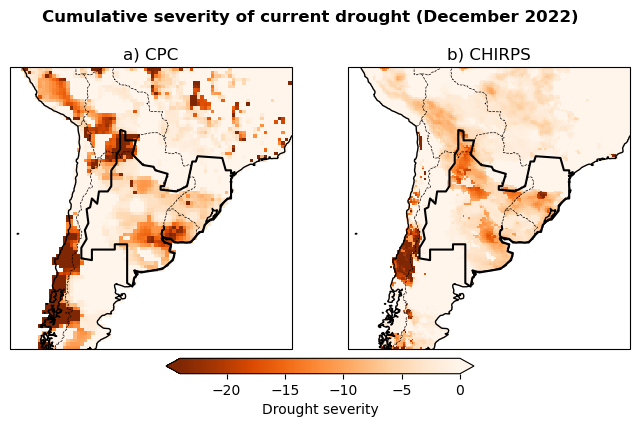

In [2]:
severity = {ens : xr.open_dataset("data/"+ens+"_spi3-drought-severity.nc").drought_severity.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps"]}

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

n_ens = len(severity.keys())
fig, axs = plt.subplots(ncols = n_ens, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (n_ens*4,4))

for i in range(n_ens):
        
    ens = list(severity.keys())[i]
    cbar = severity[ens].plot(ax = axs[i], cmap = "Oranges_r", add_colorbar = False, vmax = 0, vmin = -24)
    axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "both", label = "Drought severity")
    
plt.suptitle("Cumulative severity of current drought (December 2022)", fontweight = "bold", y = 1.02)

plt.savefig("event-map_drought-severity_dec22.png")

#### **Time series of OND severity & duration**

In [14]:
from xclim.indices.run_length import rle, _cumsum_reset_on_zero as run_cumsum

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

# fig, axs = plt.subplots(ncols = 2)

# work with mean SPI for now
for ens in ["cpc", "chirps"][:1]:
    
    da = xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True)
    
    da = da.where(rm).mean(["lat", "lon"])
    
    # identify drought months (1 if in drought, 0 otherwise)
    idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
    idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
    drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time")
    
    drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
    drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
    

---
## **Time series for climate explorer**

### **OND precipitation**

In [17]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

for ens in ["cpc", "chirps"]:
    
    csv_fnm = "ts/CSA-drought_pr-ond_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice(None, "2022")).precip
    rm = regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True)
    
    pr_ond = pr.where(rm == 1).mean(["lat", "lon"]).rolling(time = 3).mean().groupby("time.month")[12].dropna("time", "any")
    pr_ond = pr_ond.assign_coords(time = pr_ond.time.dt.year)
    
    pr_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **OND SPI**

In [69]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

for ens in ["cpc", "chirps", "mswep"]:
    
    ts = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    pr_ond = ts.to_xarray().rename(year = "time").assign_coords(time = [np.datetime64(str(y)+"-12-01") for y in ts.index]).precip
    spi_ond = get_spi(pr_ond, months = [12]).assign_coords(time = pr_ond.time.dt.year)
        
    csv_fnm = "ts/CSA-drought_spi-ond_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" OND SPI central South America drought 2022, c.barnes22@imperial.ac.uk"
    str2 = "# spi [sd] OND SPI normalised against 1980-2010 at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year spi"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    spi_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **OND temperatures (CPC only)**

In [81]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

tas = xr.open_dataset("data/cpc_tas_monthly.nc").tas

In [82]:
    ts = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    pr_ond = ts.to_xarray().rename(year = "time").assign_coords(time = [np.datetime64(str(y)+"-12-01") for y in ts.index]).precip
    spi_ond = get_spi(pr_ond, months = [12]).assign_coords(time = pr_ond.time.dt.year)
        
    csv_fnm = "ts/CSA-drought_spi-ond_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" OND SPI central South America drought 2022, c.barnes22@imperial.ac.uk"
    str2 = "# spi [sd] OND SPI normalised against 1980-2010 at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year spi"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    spi_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

NameError: name 'get_spi' is not defined

#### **Plot of PR/SPI time series**

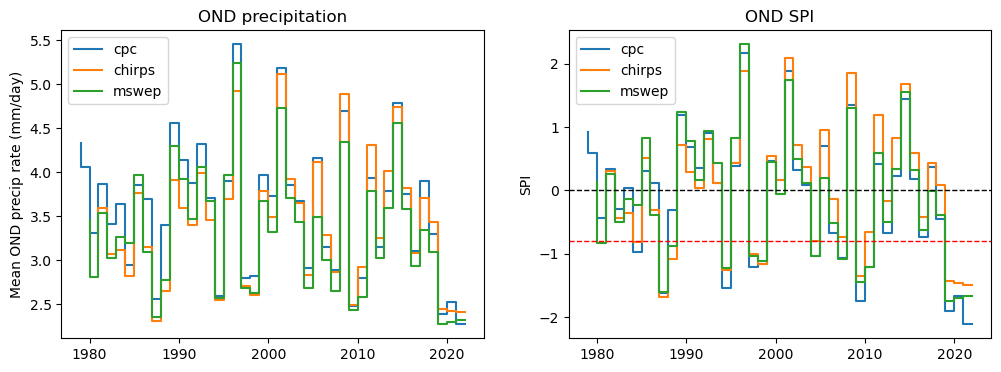

In [127]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

for ens in ["cpc", "chirps", "mswep"]:
    
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    spi = pd.read_csv("ts/CSA-drought_spi-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "spi"], index_col = "year")
    
    axs[0].step(pr.index, pr, label = ens)
    axs[1].step(spi.index, spi, label = ens)
       
axs[1].axhline(0, color = "k", ls = "--", lw = 1)
axs[1].axhline(-0.8, color = "red", ls = "--", lw = 1)

for ax in axs: ax.legend()

axs[0].set_ylabel("Mean OND precip rate (mm/day)"); axs[0].set_title("OND precipitation")
axs[1].set_ylabel("SPI"); axs[1].set_title("OND SPI")

plt.savefig("obs-timeseries.png")

#### **Precip thresholds for drought severity**

Text(0.5, 1.0, 'Conversion from SPI to precipitation thresholds')

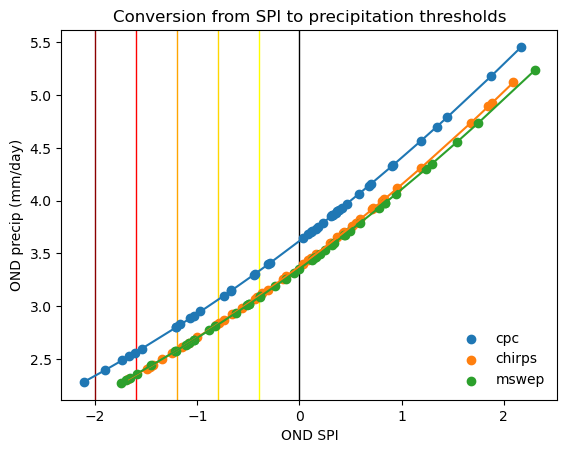

In [95]:
spi_th = {"spi_th" : [-0.4, -0.8, -1.2, -1.6, -2]}
for ens in ["cpc", "chirps", "mswep"]:
    
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year").precip
    spi = pd.read_csv("ts/CSA-drought_spi-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "spi"], index_col = "year").spi
    
    plt.scatter(spi, pr, label = ens)
    
    # add fit line
    theta = np.polyfit(spi, pr, 2)
    plt.plot(np.sort(spi), np.poly1d(theta)(np.sort(spi)))
    
    spi_th[ens] = np.poly1d(theta)(spi_th["spi_th"]).round(2)
    
[plt.axvline(y, color = c, lw = 1, zorder = -1) for y, c in zip([-2, -1.6, -1.2, -0.8, -0.4, 0], ['darkred', 'red', 'orange', 'gold','yellow', "k"])]

plt.ylabel("OND precip (mm/day)")
plt.xlabel("OND SPI")
plt.legend(edgecolor = "w")

plt.title("Conversion from SPI to precipitation thresholds")

In [110]:
spi_th = pd.DataFrame(spi_th)
spi_th.index = ["D0 - abnormally dry", "D1 - moderate drought", "D2 - severe drought", "D3 - extreme drought", "D4 - exceptional drought"]
spi_th

,spi_th,cpc,chirps,mswep
D0 - abnormally dry,-0.4,3.33,3.09,3.08
D1 - moderate drought,-0.8,3.06,2.83,2.82
D2 - severe drought,-1.2,2.80,2.58,2.58
D3 - extreme drought,-1.6,2.56,2.35,2.36
D4 - exceptional drought,-2.0,2.34,2.14,2.15


### **Check constant dispersion**

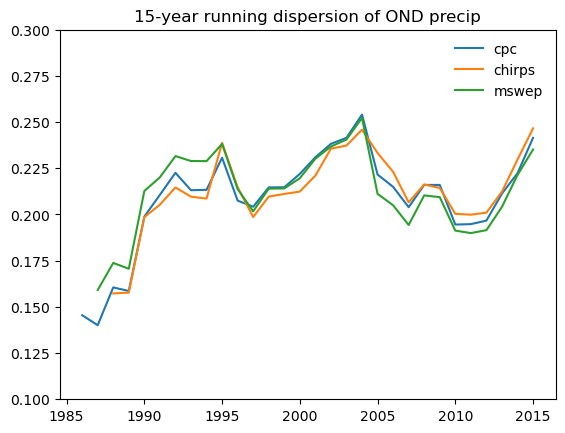

In [101]:
for ens in ["cpc", "chirps", "mswep"]:
    
    ts = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    disp = ts.rolling(15, center = True).std() / ts.rolling(15, center = True).mean()
    plt.plot(disp.index, disp, label = ens)
    
plt.legend(edgecolor = "w")
plt.title("15-year running dispersion of OND precip")
plt.ylim(0.1,0.3)

plt.savefig("running-disp.png")

### **Seasonal cycle**

In [45]:
pr = {ens : xr.open_dataset("data/"+ens+"_CSA_daily.nc").precip for ens in ["cpc", "chirps"]}  # daily data not available for MSWEP
sc = {ens : da.rolling(time = 15, center = True).mean().groupby("time.dayofyear").mean() for ens, da in pr.items()}

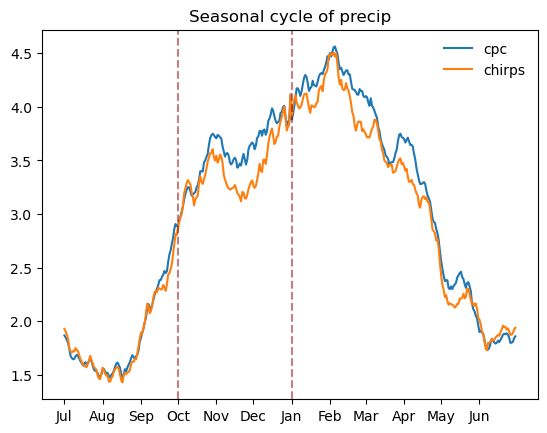

In [94]:
# adjust day of year to reflect water year (starts on July 1st)
sc = {ens : da.reindex(dayofyear = da.dayofyear.sortby((da.dayofyear + y_offset(months = 7)) % 366)) for ens, da in sc.items()}

[plt.plot(da, label = ens) for ens, da in sc.items()]
sc_xlabels(pr["cpc"].sel(time = slice("2019-07-01", "2020-06-30")).time, ax = plt.gcf().axes[0])
plt.legend(edgecolor = "w")
plt.title("Seasonal cycle of precip")
[plt.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]

plt.savefig("seasonal-cycle.png")

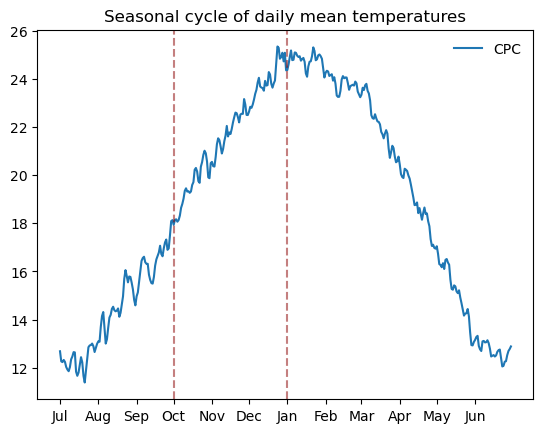

In [46]:
scm = pd.read_csv("data/cpc-tas-doy.txt", index_col = "dayofyear").to_xarray().tmean
scm = scm.reindex(dayofyear = scm.dayofyear.sortby((scm.dayofyear + y_offset(months = 7)) % 366))

plt.plot(scm, label = "CPC")
sc_xlabels(tas.sel(time = slice("2019-07-01", "2020-06-30")).time, ax = plt.gcf().axes[0])

plt.legend(edgecolor = "w")
plt.title("Seasonal cycle of daily mean temperatures")
[plt.axvline((datetime(2020,m,1).timetuple().tm_yday + y_offset(months = 7)) % 366, ls = "--", color = "darkred", alpha = 0.5) for m in [10,1]]

plt.savefig("seasonal-cycle-tas.png")

---
## **Check distribution of OND precip (stationary)**

#### **PDF**

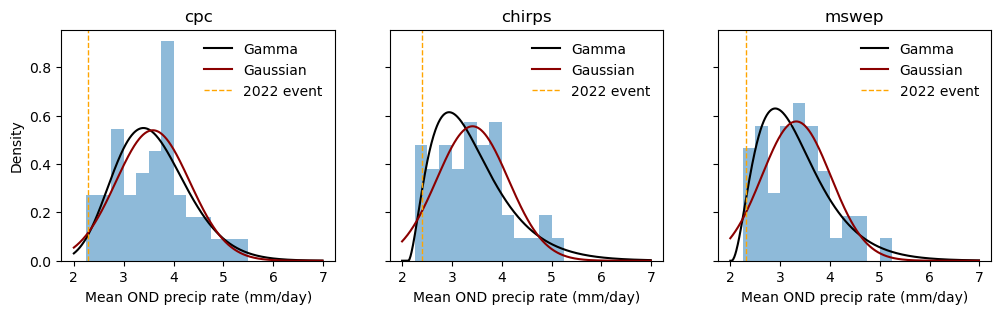

In [408]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100, sharex = True, sharey = True)

x = np.arange(2,7,0.01)

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    
    axs[i].hist(pr, bins = np.arange(2,7,0.25), density = True, alpha = 0.5)
    axs[i].plot(x, gamma.pdf(x, *gamma.fit(pr)), color = "k", label = "Gamma")
    axs[i].plot(x, norm.pdf(x, *norm.fit(pr)), color = "darkred", label = "Gaussian")
    
    axs[i].axvline(pr.loc[2022,"precip"], color = "orange", lw = 1, ls = "--", label = "2022 event")
    
    axs[i].set_title(ens)
    axs[i].set_xlabel("Mean OND precip rate (mm/day)")
    axs[i].legend(edgecolor = "w")
    
axs[0].set_ylabel("Density")

plt.savefig("obs-pdf.png")

#### **CDF**

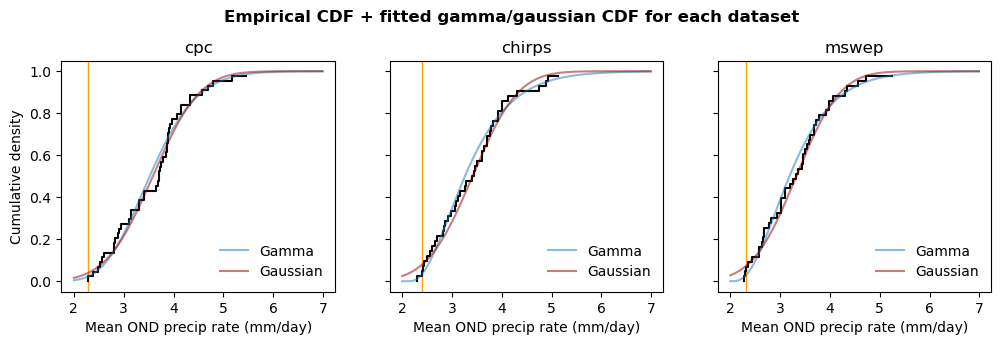

In [351]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100, sharex = True, sharey = True)
x = np.arange(2,7,0.01)

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    ecdf = np.linspace(0, 1, len(pr), endpoint=False)
    
    axs[i].axvline(pr.loc[2022,"precip"], color = "orange", lw = 1)
    axs[i].step(np.sort(pr.precip), ecdf, color = "k")
    axs[i].plot(x, gamma.cdf(x, *gamma.fit(pr)), color = "tab:blue", label = "Gamma", alpha = 0.5)
    axs[i].plot(x, norm.cdf(x, *norm.fit(pr)), color = "darkred", label = "Gaussian", alpha = 0.5)
    
    axs[i].set_title(ens)
    axs[i].set_xlabel("Mean OND precip rate (mm/day)")
    
    axs[i].legend(edgecolor = "w")
    
axs[0].set_ylabel("Cumulative density")

plt.suptitle("Empirical CDF + fitted gamma/gaussian CDF for each dataset", y = 1.05, fontweight = "bold")

plt.savefig("obs-cdf.png")

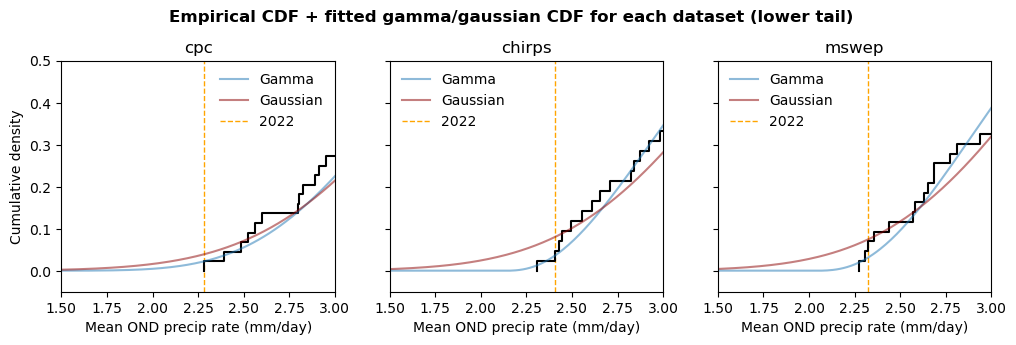

In [349]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100, sharex = True, sharey = True)
x = np.arange(0.01,7,0.01)

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    ecdf = np.linspace(0, 1, len(pr), endpoint=False)
    
    axs[i].step(np.sort(pr.precip), ecdf, color = "k")
    axs[i].plot(x, gamma.cdf(x, *gamma.fit(pr)), color = "tab:blue", label = "Gamma", alpha = 0.5)
    axs[i].plot(x, norm.cdf(x, *norm.fit(pr)), color = "darkred", label = "Gaussian", alpha = 0.5)
    axs[i].axvline(pr.loc[2022,"precip"], color = "orange", lw = 1, ls = "--", label = "2022", zorder = -1)

    axs[i].set_title(ens)
    axs[i].set_xlabel("Mean OND precip rate (mm/day)")
    
    axs[i].legend(edgecolor = "w")
    axs[i].set_xlim(1.5, 3)
    axs[i].set_ylim(None, 0.5)
    
axs[0].set_ylabel("Cumulative density")

plt.suptitle("Empirical CDF + fitted gamma/gaussian CDF for each dataset (lower tail)", y = 1.05, fontweight = "bold")

plt.savefig("obs-cdf_lower-tail.png")

#### **Q-Q plot**

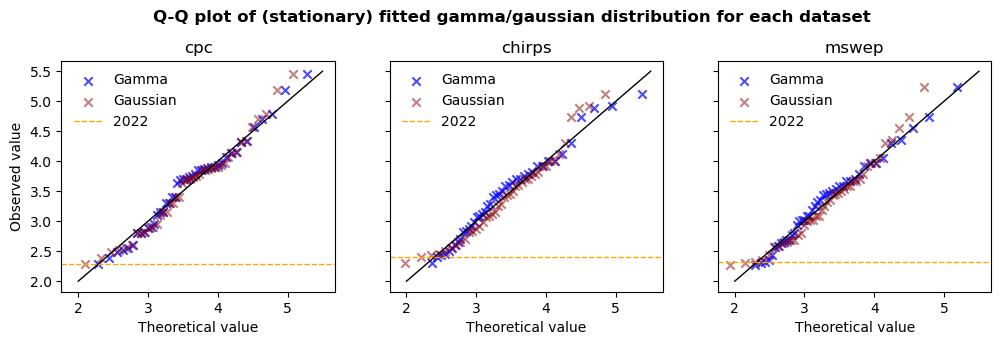

In [403]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100, sharex = True, sharey = True)
x = np.arange(2,7,0.01)

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    
    axs[i].scatter(gamma.ppf(np.linspace(0,1,len(pr)+1, endpoint = False)[1:], *gamma.fit(pr)), np.sort(pr.precip), label = "Gamma", marker = "x", color = "blue", alpha = 0.7)
    axs[i].scatter(norm.ppf(np.linspace(0,1,len(pr)+1, endpoint = False)[1:], *norm.fit(pr)), np.sort(pr.precip), label = "Gaussian", marker = "x", color = "darkred", alpha = 0.5)
    axs[i].plot((2,5.5),(2,5.5), lw = 1, color = "k")
    axs[i].axhline(pr.loc[2022,"precip"], color = "orange", lw = 1, ls = "--", label = "2022")
    
    axs[i].set_title(ens)
    axs[i].set_xlabel("Theoretical value")
    
    axs[i].legend(edgecolor = "w")
        
axs[0].set_ylabel("Observed value")

plt.suptitle("Q-Q plot of (stationary) fitted gamma/gaussian distribution for each dataset", y = 1.05, fontweight = "bold")

plt.savefig("obs-qqplot.png")

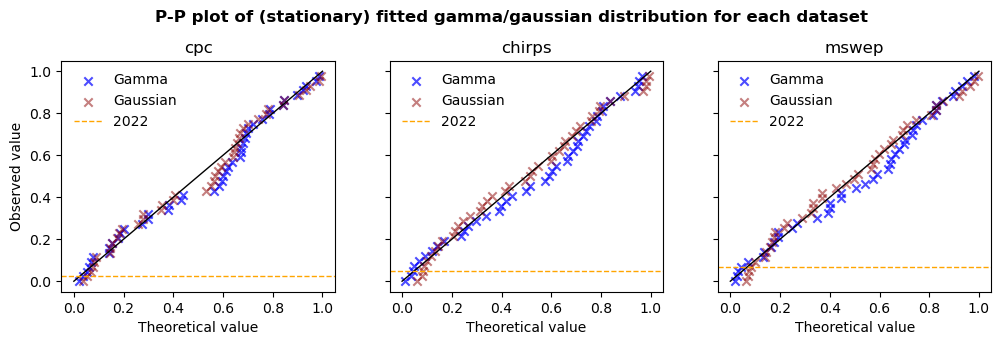

In [404]:
fig, axs = plt.subplots(ncols = 3, figsize = (12,3), dpi = 100, sharex = True, sharey = True)
x = np.arange(2,7,0.01)

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    
    axs[i].scatter(gamma.cdf(np.sort(pr.precip), *gamma.fit(pr)), np.linspace(0, 1, len(pr), endpoint=False), label = "Gamma", marker = "x", color = "blue", alpha = 0.7)
    axs[i].scatter(norm.cdf(np.sort(pr.precip), *norm.fit(pr)), np.linspace(0, 1, len(pr), endpoint=False), label = "Gaussian", marker = "x", color = "darkred", alpha = 0.5)
    axs[i].plot((0,1),(0,1), lw = 1, color = "k")
    axs[i].axhline(np.linspace(0, 1, len(pr), endpoint=False)[int(pr.rank().loc[2022].precip)], color = "orange", lw = 1, ls = "--", label = "2022")
    
    axs[i].set_title(ens)
    axs[i].set_xlabel("Theoretical value")
    
    axs[i].legend(edgecolor = "w")
        
axs[0].set_ylabel("Observed value")

plt.suptitle("P-P plot of (stationary) fitted gamma/gaussian distribution for each dataset", y = 1.05, fontweight = "bold")

plt.savefig("obs-ppplot.png")

#### **Fit statistics**

In [381]:
fit = {}

for i in range(3):
    ens = ["cpc", "chirps", "mswep"][i]
    pr = pd.read_csv("ts/CSA-drought_pr-ond_"+ens+".dat", comment = "#", sep = " ", header = None, names = ["year", "precip"], index_col = "year")
    ecdf = np.linspace(0, 1, len(pr), endpoint=False)
    
    # Kolmogorov-Smirnov distance for full distribution & for lower tail; also exceedance probability & return time
    fit[ens] = {"ks_gamma_all" : sum(abs(gamma.cdf(np.sort(pr.precip), *gamma.fit(pr)) - ecdf)),
                "ks_norm_all"  : sum(abs(norm.cdf(np.sort(pr.precip), *norm.fit(pr)) - ecdf)),
                "ks_gamma_lt"  : sum(abs(gamma.cdf(np.sort(pr.precip), *gamma.fit(pr)) - ecdf)[:10]),
                "ks_norm_lt"   : sum(abs(norm.cdf(np.sort(pr.precip), *norm.fit(pr)) - ecdf)[:10]),
                "ep_gamma"     : gamma.cdf(pr.loc[2022,"precip"], *gamma.fit(pr)),
                "rp_gamma"     : 1/gamma.cdf(pr.loc[2022,"precip"], *gamma.fit(pr)),
                "ep_norm"      : norm.cdf(pr.loc[2022,"precip"], *norm.fit(pr)),
                "rp_norm"      : 1/norm.cdf(pr.loc[2022,"precip"], *norm.fit(pr))}
    
fit = pd.DataFrame(fit)

In [386]:
fit.loc[["rp_gamma", "rp_norm"]].round()

,cpc,chirps,mswep
rp_gamma,45.0,27.0,33.0
rp_norm,26.0,12.0,14.0


## **Station data**

### **Validation against station data**

In [3]:
obs = pd.read_csv("stations/station-ond.csv", index_col = "fecha")
gdf = pd.read_csv("station-data.csv", index_col ="omm_id")

cpc, chirps, mswep = [pd.read_csv("stations/"+ds+"station-ond.csv", index_col = "time") for ds in ["cpc", "chirps", "mswep"]]
cpc.index = [int(i[:4]) for i in cpc.index]; chirps.index = [int(i[:4]) for i in chirps.index]; mswep.index = [int(i[:4]) for i in mswep.index]

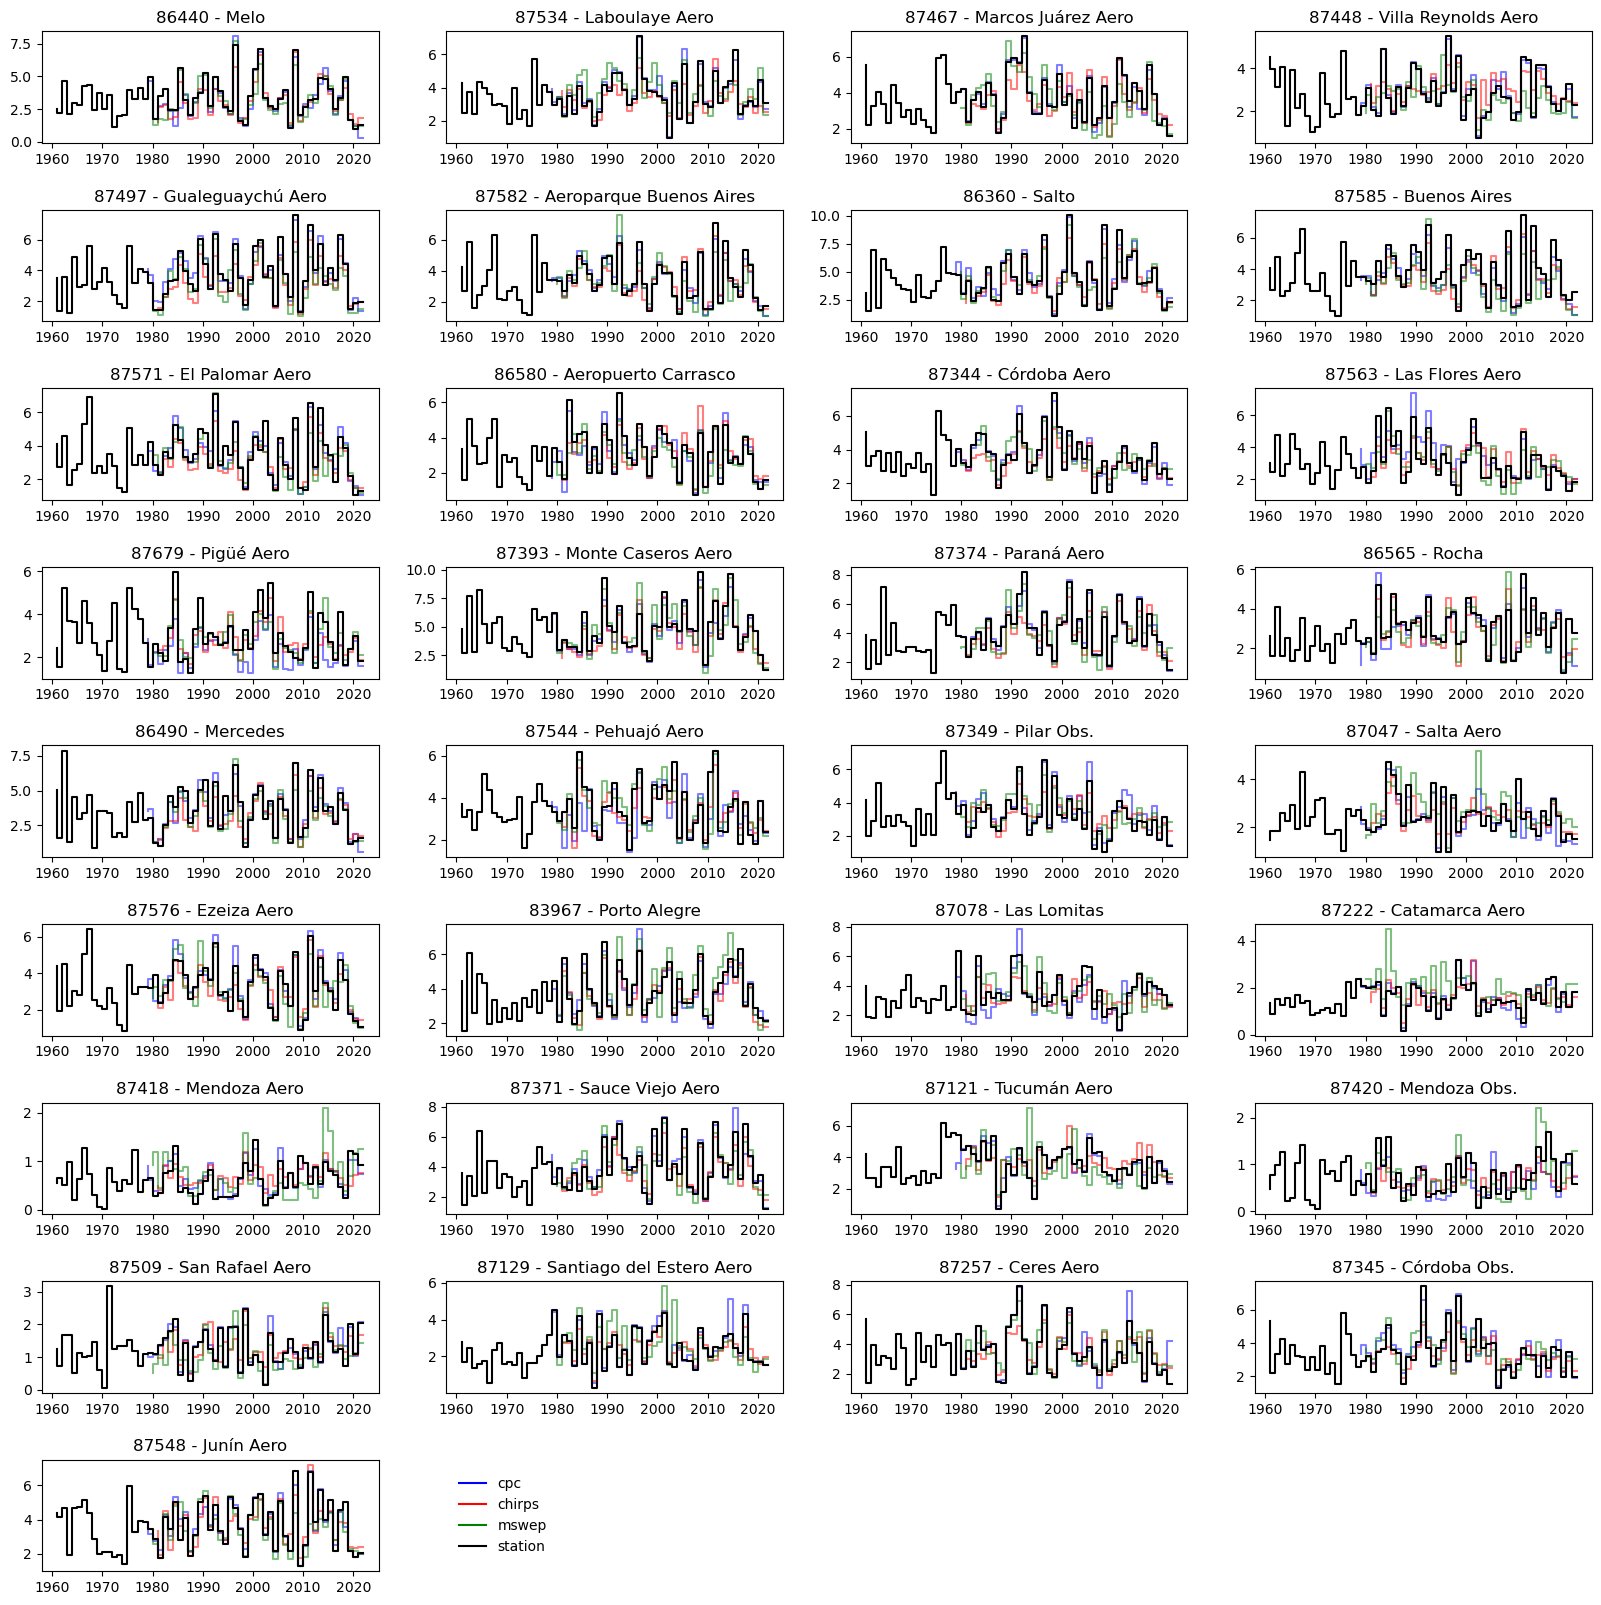

In [13]:
fig, axs = plt.subplots(ncols = 4, nrows = 9, figsize = (20,20), dpi = 100)
plt.subplots_adjust(hspace = 0.6)

for i in range(obs.shape[1]):
    
    stn = obs.columns[i]
    ax = fig.axes[i]
    
    ax.step(cpc.index, cpc[[stn]], color = "blue", alpha = 0.5)
    ax.step(chirps.index, chirps[[stn]], color = "red", alpha = 0.5)
    ax.step(mswep.index, mswep[[stn]], color = "green", alpha = 0.5)
    ax.step(obs.index, obs[[stn]], color = "k")
    
    ax.set_xlabel("")
    ax.set_title(stn+" - "+gdf.loc[int(stn)].nombre)
    
for i in range(obs.shape[1], axs.shape[0] * axs.shape[1]): fig.axes[i].set_axis_off()

fig.axes[obs.shape[1]].legend(handles = [matplotlib.lines.Line2D([], [], color = c, label = l) for c, l in zip(["blue", "red", "green", "k"], ["cpc", "chirps", "mswep", "station"])],
                              loc = "center left", edgecolor = "w")

plt.savefig("station-validation.png")

### **Create time series for climate explorer**

In [24]:
obs = pd.read_csv("stations/station-ond.csv", index_col = "fecha", parse_dates = False)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]]

for c in obs.columns:
        
    csv_fnm = "ts/CSA-drought_pr-ond_station-"+c+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: station "+c+" OND precip central South America drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] OND mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    obs[[c]].to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Event map with stations included**

In [83]:
obs = pd.read_csv("stations/station-ond.csv", index_col = "fecha", parse_dates = True)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]]
gdf = pd.read_csv("station-data.csv", index_col = "omm_id").loc[[int(c) for c in obs.columns]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

# load latest data, discretize to get drought classifications
spi = {ens : xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi.sel(time = "2022-12").squeeze(drop = True) for ens in ["cpc", "chirps", "mswep"]}
spi = {k : xr.apply_ufunc(np.digitize, v, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(v)) for k, v in spi.items()}

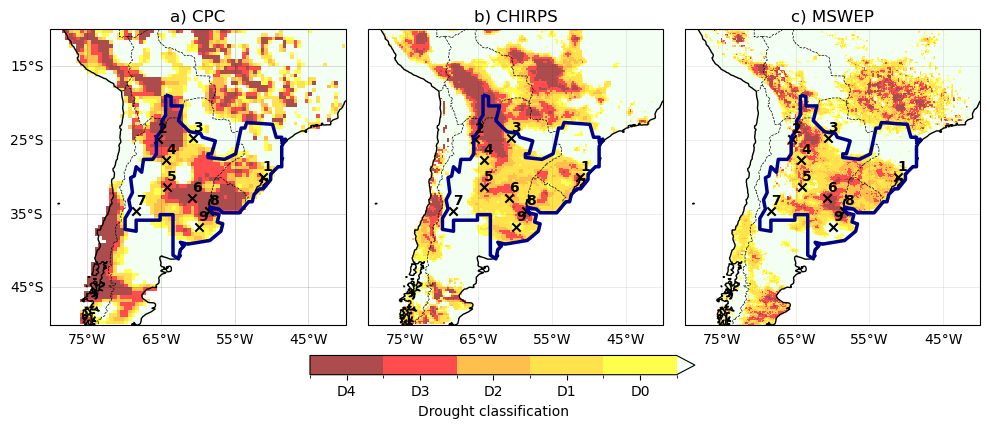

In [84]:
cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "alpha" : 0.7, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

n_ens = len(spi.keys())
fig, axs = plt.subplots(ncols = n_ens, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (12,5), sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0.075)

for i in range(n_ens):
        
    ens = list(spi.keys())[i]
    cbar = spi[ens].plot(ax = axs[i], **plot_kwargs); axs[i].set_title(chr(i+97)+") "+ens.upper())
    
for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
    ax.scatter(gdf.longitud, gdf.latitud, marker = "x", color = "k")
    # [ax.annotate(str(k), xy = [v.longitud, v.latitud], textcoords="offset points", xytext=(5,3), ha = 'left', fontweight = "bold") for k,v in gdf.iterrows()]
    [ax.annotate(str(list(gdf.index).index(k)+1), xy = [v.longitud, v.latitud], textcoords="offset points", xytext=(0,5), ha = 'left', fontweight = "bold") for k,v in gdf.iterrows()]
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))

axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))

cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.08, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])

# plt.suptitle("Drought classification in December 2022 based on 3-month SPI", fontweight = "bold", y = 1.02)

plt.savefig("event-map_spi3_dec22.png")

In [85]:
obs = pd.read_csv("stations/station-ond.csv", index_col = "fecha", parse_dates = False)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]]
gdf = pd.read_csv("station-data.csv", index_col ="omm_id")

cpc, chirps, mswep = [pd.read_csv("stations/"+ds+"station-ond.csv", index_col = "time") for ds in ["cpc", "chirps", "mswep"]]
cpc.index = [int(i[:4]) for i in cpc.index]; chirps.index = [int(i[:4]) for i in chirps.index]; mswep.index = [int(i[:4]) for i in mswep.index]

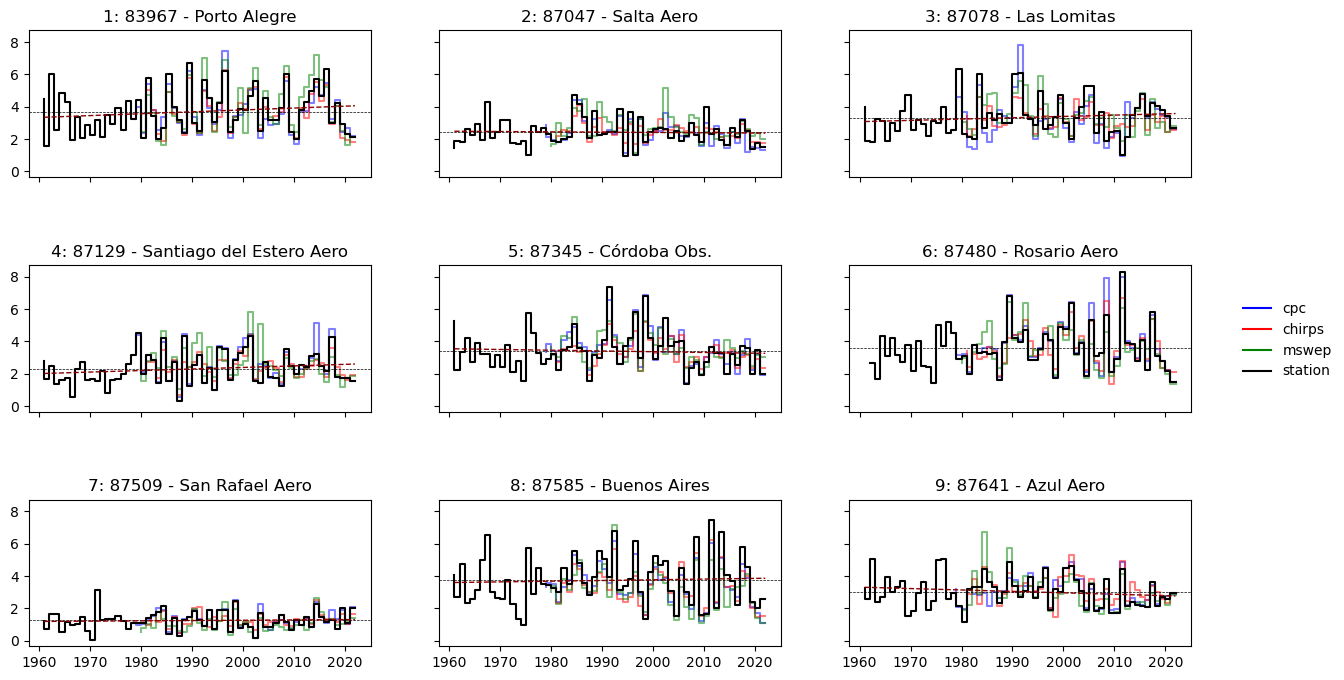

In [91]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize = (15,8), dpi = 100, sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.6)

for i in range(obs.shape[1]):
    
    stn = obs.columns[i]
    ax = fig.axes[i]
    
    ax.step(cpc.index, cpc[[stn]], color = "blue", alpha = 0.5)
    ax.step(chirps.index, chirps[[stn]], color = "red", alpha = 0.5)
    ax.step(mswep.index, mswep[[stn]], color = "green", alpha = 0.5)
    ax.step(obs.index, obs[[stn]], color = "k")
    
    ax.set_xlabel("")
    ax.set_title(str(i+1)+": "+stn+" - "+gdf.loc[int(stn)].nombre)
    
    ax.axhline(obs[stn].mean(), lw = 0.5, ls = "--", color = "k")
    
    # add fit line
    theta = np.polyfit(obs.index, obs[stn], 1)
    ax.plot(np.sort(obs.index), np.poly1d(theta)(np.sort(obs.index)), color = "darkred", ls = "--", lw = 1)
    

fig.legend(handles = [matplotlib.lines.Line2D([], [], color = c, label = l) for c, l in zip(["blue", "red", "green", "k"], ["cpc", "chirps", "mswep", "station"])],
                              loc = "center right", edgecolor = "w")

plt.savefig("station-validation.png")

### **CX trend plots**

In [1]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from wwa_nonstationary_fitting import *

In [2]:
obs = pd.merge(pd.read_csv("/home/clair/wwa/90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["fecha","gmst"]),
               pd.read_csv("stations/station-ond.csv", )[["fecha"] + [str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]]).set_index("fecha")
gdf = pd.read_csv("station-data.csv", index_col ="omm_id")

event_gmst = obs.loc[2022, "gmst"]

In [3]:
# check return periods at each station
stn_fit = pd.DataFrame({stn : model_results(ns_fit(lognorm, "fixeddisp", obs, "gmst", stn, tol = 1e-5), event_gmst, event_gmst - 1.2, event_value = obs.loc[2022, stn], lower = True) for stn in obs.columns[1:]}).transpose()
stn_fit

,mu,sigma,alpha,loc1,scale1,disp1,loc2,scale2,disp2,fixed_value,rp_1,rp_2,pr,fixed_rp,rl_1,rl_2,dI
83967,1.172342,0.334233,0.184187,1.354476,0.386159,0.285098,1.121741,0.319806,0.285098,2.145349,15.899244,7.622721,0.479439,NaN,NaN,NaN,NaN
87047,0.878998,0.347238,-0.127640,0.769168,0.303851,0.395039,0.915584,0.361692,0.395039,1.526087,7.868143,11.562252,1.469502,NaN,NaN,NaN,NaN
87078,1.090543,0.329122,0.137854,1.224909,0.369674,0.301797,1.052508,0.317644,0.301797,2.701087,3.762218,2.344642,0.623207,NaN,NaN,NaN,NaN
87129,0.709778,0.476253,0.056152,0.763314,0.512175,0.670989,0.694182,0.465789,0.670989,1.530435,3.924672,3.545297,0.903336,NaN,NaN,NaN,NaN
87345,1.209286,0.352404,-0.116795,1.106558,0.322467,0.291415,1.242534,0.362093,0.291415,1.993478,10.188285,15.755325,1.546416,NaN,NaN,NaN,NaN
87480,1.212114,0.384830,0.000000,1.212114,0.384830,0.317487,1.212114,0.384830,0.317487,1.517391,51.529006,51.529006,1.000000,NaN,NaN,NaN,NaN
87509,0.116436,0.744236,-0.064272,0.070104,0.448087,6.391779,0.135960,0.869028,6.391779,2.047826,1.080478,1.336816,1.237245,NaN,NaN,NaN,NaN
87585,1.208764,0.435528,0.048665,1.254333,0.451947,0.360309,1.195174,0.430632,0.360309,2.558696,4.114884,3.618623,0.879398,NaN,NaN,NaN,NaN
87641,1.145832,0.343102,-0.239921,0.945228,0.283034,0.299435,1.215230,0.363882,0.299435,2.964130,1.446629,2.763633,1.910395,NaN,NaN,NaN,NaN


/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


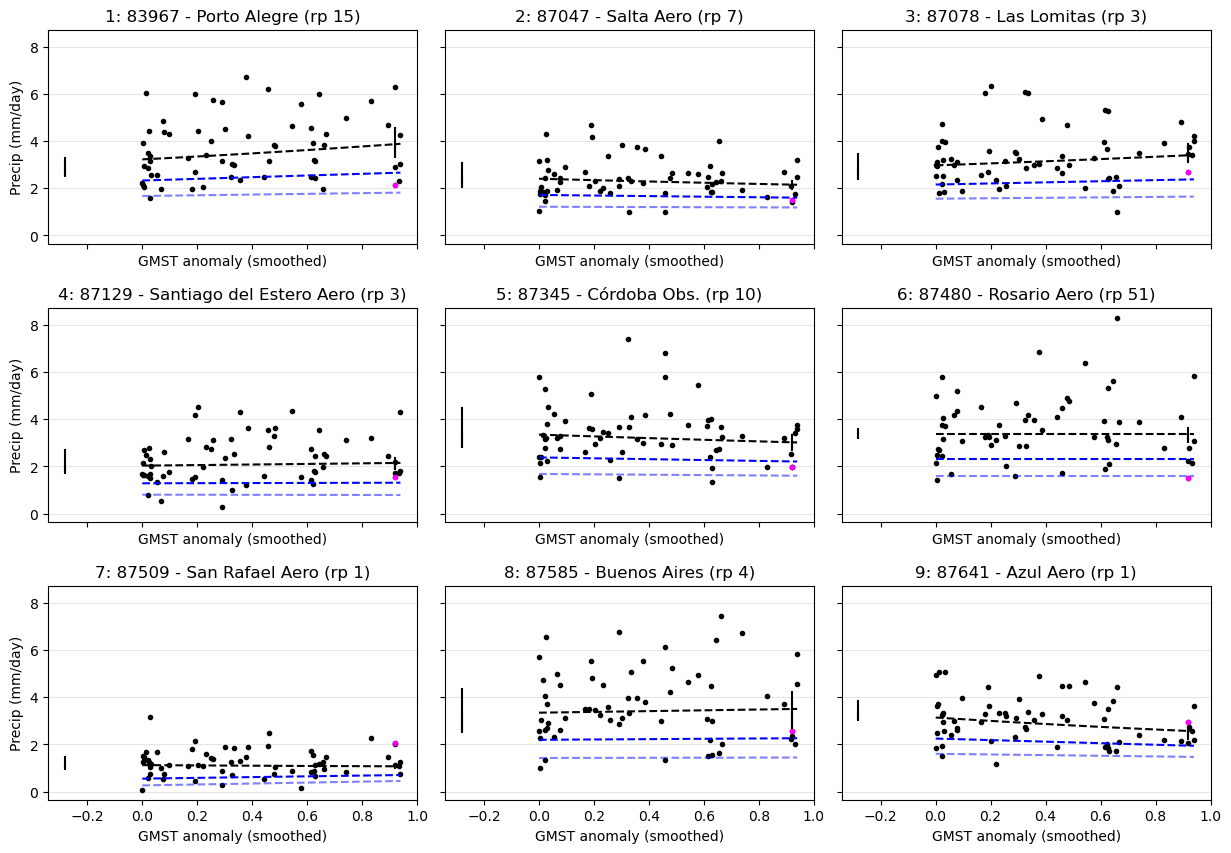

In [4]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, dpi = 100, figsize = (15,10), sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3, wspace = 0.075)

for i in range(9):
    
    stn = obs.columns[i+1]
    mdl = ns_fit(lognorm, "fixeddisp", obs, "gmst", stn, tol = 1e-5)
    rp = str(int(return_period(mdl, covariate = event_gmst, event_value = obs.loc[2022, stn], lower = True)))
    
    ax = fig.axes[i]
    
    boot_ci = boot_results(mdl, event_gmst, event_gmst - 1.2, nsamp = 10)    
    trendplot(mdl, event_gmst, event_gmst - 1.2, loc1 = boot_ci["loc1"].values.flatten(), loc2 = boot_ci["loc2"].values.flatten(), ax = ax)
    
    # trendplot(mdl, event_gmst, event_gmst - 1.2, ax = ax)
    ax.set_title(str(i+1)+": "+stn+" - "+gdf.loc[int(stn)].nombre + " (rp "+rp+")")
    ax.grid(axis = "y", color = "k", alpha = 0.1)

for ax in axs[:,0]: ax.set_ylabel("Precip (mm/day)")

plt.savefig("stations-fitted-trendplots.png")

### **CX return level plots**

In [8]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from wwa_nonstationary_fitting import *

obs = pd.merge(pd.read_csv("/home/clair/wwa/90_data/gmst.dat", comment = "#", sep = " .", engine = "python", header = None, names = ["fecha","gmst"]),
               pd.read_csv("stations/station-ond.csv", )[["fecha"] + [str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]]).set_index("fecha")
gdf = pd.read_csv("station-data.csv", index_col ="omm_id")
obs = np.log10(obs)
event_gmst = obs.loc[2022, "gmst"]

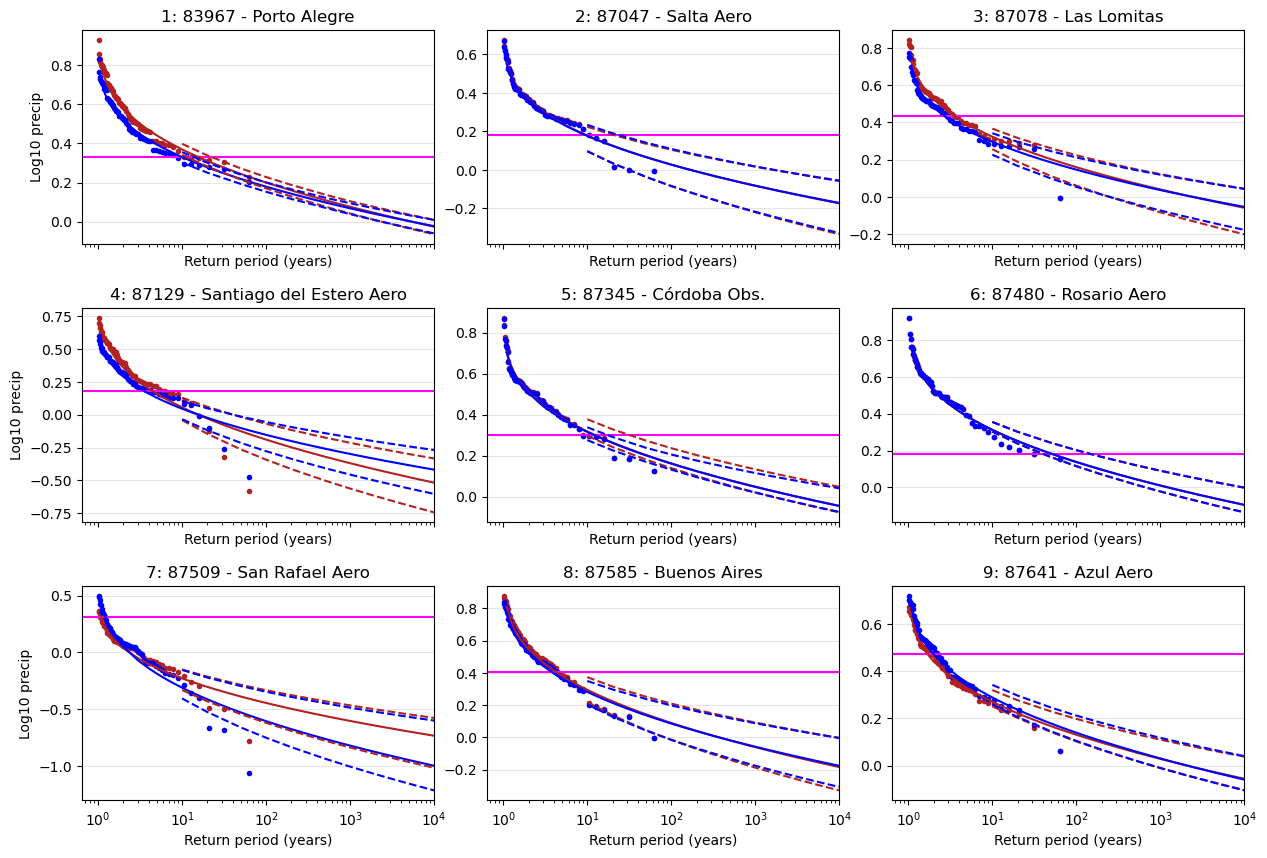

In [16]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, dpi = 100, figsize = (15,10), sharex = True, sharey = False)
plt.subplots_adjust(hspace = 0.3, wspace = 0.15)

for i in range(9):
    
    stn = obs.columns[i+1]
    mdl = ns_fit(norm, "fixeddisp", obs, "gmst", stn, tol = 1e-5)
    ax = fig.axes[i]
    
    rlplot(mdl, event_gmst, event_gmst - 1.2, obs.loc[2022, stn], lower = True, ax = ax)
    
    # trendplot(mdl, event_gmst, event_gmst - 1.2, ax = ax)
    ax.set_title(str(i+1)+": "+stn+" - "+gdf.loc[int(stn)].nombre)
    ax.grid(axis = "y", color = "k", alpha = 0.1)
    
for ax in axs[:,0]: ax.set_ylabel("Log10 precip")

plt.savefig("stations-fitted-returnperiods.png")

---
## **Correlations with Nino3.4**

In [2]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

nino = decode_times(xr.open_dataset("/home/clair/Downloads/iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"].resample(time = "MS").mean().sel(time = slice("1981", "2022"))

cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.sel(time = slice("1981", "2022"))
chirps = xr.open_dataset("data/chirps_precip_monthly.nc").precip.sel(time = slice("1981", "2022"))
mswep = xr.open_dataset("data/mswep_precip_monthly.nc").precip.sel(time = slice("1981", "2022")).sel(lat = slice(-50,-10), lon = slice(-80, -40))

# OND mean only
cpc, chirps, mswep, nino = [da.sel(time = [m in [10,11,12] for m in da.time.dt.month]).resample(time = "AS-JUL").mean() for da in [cpc, chirps, mswep, nino]]

cpc_csa, chirps_csa, mswep_csa = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]) for da in [cpc, chirps, mswep]]
cpc_map, chirps_map, mswep_map = [xr.apply_ufunc(lambda ts : np.corrcoef(nino.values, ts)[0,1], da, input_core_dims = [["time"]], vectorize = True) for da in [cpc, chirps, mswep]]


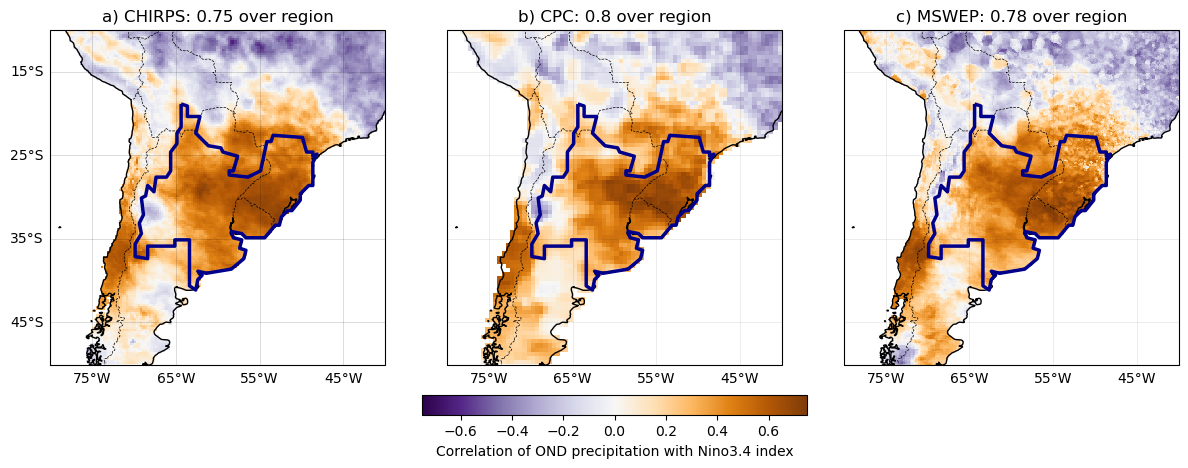

In [7]:
fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (15,5), sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0.075)

plot_kwargs = {"vmin" : -0.75, "vmax" : 0.75, "cmap" : "PuOr_r", "add_colorbar" : False}

cbar = chirps_map.plot(ax = axs[0], **plot_kwargs); axs[0].set_title(chr(97)+") CHIRPS: "+str(xr.corr(nino, chirps_csa).values.round(2))+" over region")
cpc_map.plot(ax = axs[1], **plot_kwargs); axs[1].set_title(chr(98)+") CPC: "+str(xr.corr(nino, cpc_csa).values.round(2))+" over region")
mswep_map.plot(ax = axs[2], **plot_kwargs); axs[2].set_title(chr(99)+") MSWEP: "+str(xr.corr(nino, mswep_csa).values.round(2))+" over region")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.08, label = "Correlation of OND precipitation with Nino3.4 index")
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = range(-75,-35,10), ylocs = range(-45,-5,10))

plt.savefig("precip-nino-correlation.png")